[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ContextLab/spam-classifier-llm-course/blob/main/Assignment2_SPAM_Classifier.ipynb)

# Assignment 2: Advanced SPAM Classifier with Multi-Method Comparison

**Course:** PSYC 51.17 - Models of Language and Communication  
**Deadline:** January 26, 2026 at 11:59 PM EST

---

## Overview

In this assignment, you will build a comprehensive spam classification system that implements multiple classification approaches, conducts rigorous comparative analysis, and performs extensive error analysis.

Please refer to the [full assignment instructions](https://contextlab.github.io/llm-course/assignments/assignment-2/) for detailed requirements and grading rubric.

---

## Table of Contents

1. [Setup and Data Loading](#setup)
2. [Part 1: Classifier Implementations](#part1)
3. [Part 2: Comprehensive Evaluation](#part2)
4. [Part 3: Error Analysis](#part3)
5. [Part 4: Adversarial Testing](#part4)
6. [Part 5: Real-World Considerations](#part5)
7. [Discussion and Reflection](#discussion)

<a id='setup'></a>
## 1. Setup and Data Loading

In [1]:
# Install required packages
!pip install -q transformers datasets scikit-learn pandas numpy matplotlib seaborn

In [2]:
import os
import zipfile
import urllib.request
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

# Set random seed for reproducibility
np.random.seed(42)

print("Setup complete!")

Setup complete!


In [3]:
# Download the training dataset
dataset_url = 'https://raw.githubusercontent.com/ContextLab/spam-classifier-llm-course/main/training.zip'
dataset_path = 'training.zip'

if not os.path.exists(dataset_path):
    print("Downloading dataset...")
    urllib.request.urlretrieve(dataset_url, dataset_path)
    print("Download complete.")
else:
    print("Dataset already exists.")

Download complete.


In [4]:
def load_dataset(zip_path):
    """
    Load emails from a zip archive containing spam/ and ham/ folders.

    Returns:
        emails: List of email texts
        labels: List of labels (1 for spam, 0 for ham)
    """
    # Extract if needed
    dataset_dir = Path(zip_path).with_suffix('')
    if not dataset_dir.exists():
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(dataset_dir)

    emails = []
    labels = []

    # Load spam
    spam_folder = dataset_dir / "training/spam"
    for file_path in spam_folder.iterdir():
        if file_path.is_file():
            with open(file_path, 'r', encoding='utf-8', errors='ignore') as f:
                emails.append(f.read())
                labels.append(1)

    # Load ham
    ham_folder = dataset_dir / "training/ham"
    for file_path in ham_folder.iterdir():
        if file_path.is_file():
            with open(file_path, 'r', encoding='utf-8', errors='ignore') as f:
                emails.append(f.read())
                labels.append(0)

    return emails, labels

emails, labels = load_dataset('training.zip')
print(f"Loaded {len(emails)} emails")
print(f"Spam: {sum(labels)}, Ham: {len(labels) - sum(labels)}")

Loaded 25287 emails
Spam: 12956, Ham: 12331


In [5]:
# TODO: Split data into train/validation/test sets
from sklearn.model_selection import train_test_split

# First split: train (70%) and temp (30%)
X_train, X_temp, y_train, y_temp = train_test_split(
    emails,
    labels,
    test_size=0.30,
    random_state=42,
    stratify=labels
)

# Second split: validation (15%) and test (15%)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp,
    y_temp,
    test_size=0.50,
    random_state=42,
    stratify=y_temp
)

print("Dataset splits:")
print(f"Train: {len(X_train)}")
print(f"Validation: {len(X_val)}")
print(f"Test: {len(X_test)}")

print("\nClass distribution:")
print(f"Train spam: {sum(y_train)}, ham: {len(y_train) - sum(y_train)}")
print(f"Val spam: {sum(y_val)}, ham: {len(y_val) - sum(y_val)}")
print(f"Test spam: {sum(y_test)}, ham: {len(y_test) - sum(y_test)}")

Dataset splits:
Train: 17700
Validation: 3793
Test: 3794

Class distribution:
Train spam: 9069, ham: 8631
Val spam: 1943, ham: 1850
Test spam: 1944, ham: 1850


<a id='part1'></a>
## 2. Part 1: Multiple Classifier Implementations (40 points)

### 2.1 Traditional ML Baseline (15 points)

Implement **two** traditional ML classifiers with TF-IDF features.

## Traditional Machine Learning Methods: Design Choices and Justification

### Feature Representation: TF-IDF

I used a TF-IDF (Term Frequency–Inverse Document Frequency) representation to convert raw email text into numerical features suitable for traditional machine learning classifiers. TF-IDF is well suited for spam classification because it emphasizes words that are frequent in a particular email but rare across the corpus, which aligns well with how spam often contains distinctive lexical markers.

**Parameter choices and rationale:**

* `lowercase=True`
  All text is lowercased to reduce sparsity caused by casing differences (e.g "FREE" vs "free"). This is a standard normalization step in text classification and helps traditional models generalize better.

* `stop_words=english`
  Common function words (e.g "the", "and", "is") carry little discriminative value for spam detection. Removing them reduces noise and dimensionality, improving both efficiency and performance.

* `ngram_range=(1, 2)`
  I included both unigrams and bigrams. While single words capture basic lexical cues, bigrams allow the model to detect short spam phrases such as "free money", "limited offer", or "click here", which are highly informative for spam classification.

* `min_df=2`
  Tokens that appear in only one document are removed. These extremely rare terms are often typos, artifacts, or idiosyncratic content that do not generalize and can harm model robustness.

* `max_df=0.95`
  Tokens that appear in more than 95 percent of documents are removed, since they provide little discriminative power and behave similarly to stop words.

* `sublinear_tf=True`
  Log-scaled term frequency reduces the dominance of very long emails and prevents raw token counts from overwhelming the model. This is particularly important because spam emails can be unusually repetitive.

* `norm=l2`
  L2 normalization ensures feature vectors have comparable magnitudes, which is especially important for linear models such as SVMs that rely on geometric margins.

### Classifier 1: Multinomial Naive Bayes

The first traditional baseline is **Multinomial Naive Bayes**, a probabilistic model that has historically performed well on text classification tasks.

**Justification:**

* Naive Bayes assumes conditional independence between features, which is violated in natural language, but in practice it performs surprisingly well for bag-of-words and TF-IDF representations.
* It is extremely fast to train and evaluate, making it a strong efficiency baseline.
* Its probabilistic outputs are useful for threshold-based analysis and ensemble methods.

**Hyperparameters:**

* `alpha=1.0`
  This applies Laplace smoothing, preventing zero probabilities for unseen tokens at test time. This improves robustness, especially when encountering rare or novel spam patterns.

### Classifier 2: Linear Support Vector Machine (SVM)

The second traditional classifier is a **linear SVM**, which is widely regarded as one of the strongest classical models for high-dimensional sparse text data.

**Justification:**

* Linear SVMs are well suited to TF-IDF features, where the number of dimensions can be very large.
* The margin-based objective focuses on difficult boundary cases, which is important for minimizing false positives in spam detection.
* Compared to Naive Bayes, SVMs typically achieve higher precision and F1 scores, at the cost of increased computational complexity.

**Hyperparameters:**

* `kernel='linear'`
  A linear kernel is computationally efficient and appropriate for text data, where decision boundaries are often approximately linear in TF-IDF space.

* `C=1.0`
  This regularization strength balances margin maximization and classification error. A moderate default value was chosen to avoid overfitting while maintaining strong performance.

* `probability=True`
  Probability estimates were enabled to allow ROC-AUC evaluation and to support soft-voting in the ensemble model. Although this slightly increases training cost, it enables richer comparative analysis.

### Preprocessing Summary

No stemming or lemmatization was applied. While these techniques can reduce sparsity, they may also remove meaningful distinctions in spam-related language (e.g "offer" vs "offering"). Instead, the combination of TF-IDF weighting, n-grams, and document frequency thresholds provided a strong balance between expressiveness and generalization.

### Summary

Overall, the traditional ML pipeline was designed to be:

* **Interpretable**, through explicit feature weights and token-level analysis
* **Efficient**, particularly in comparison to transformer-based models
* **Strongly competitive**, serving as a meaningful baseline against which to evaluate neural and ensemble approaches

These design choices ensured a fair, well-justified comparison between classical and modern methods in the later evaluation sections.


In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# TODO: Implement TF-IDF vectorizer with appropriate parameters
# Document your feature engineering choices

vectorizer = TfidfVectorizer(
    lowercase=True,            # Normalize casing (e.g., "FREE" vs "free")
    stop_words='english',      # Remove common function words with low signal
    ngram_range=(1, 2),        # Unigrams + bigrams capture short spam phrases
    min_df=2,                  # Remove extremely rare tokens (noise)
    max_df=0.95,               # Remove near-constant terms
    sublinear_tf=True,         # Log-scaled term frequency (robust to long emails)
    norm='l2'                  # Required for linear SVM geometry
)

X_train_tfidf = vectorizer.fit_transform(X_train)
X_val_tfidf = vectorizer.transform(X_val)
X_test_tfidf = vectorizer.transform(X_test)

print("TF-IDF shapes:")
print("Train:", X_train_tfidf.shape)
print("Val:", X_val_tfidf.shape)
print("Test:", X_test_tfidf.shape)

# TODO: Implement first traditional classifier
classifier1 = MultinomialNB(
    alpha=1.0   # Laplace smoothing for robustness to unseen tokens
)
classifier1.fit(X_train_tfidf, y_train)

# TODO: Implement second traditional classifier
classifier2 = SVC(
    kernel='linear',    # Linear kernel scales well for high-dimensional text
    C=1.0,              # Regularization strength
    probability=True,   # Enables ROC/AUC evaluation
    random_state=42
)

classifier2.fit(X_train_tfidf, y_train)

TF-IDF shapes:
Train: (17700, 362124)
Val: (3793, 362124)
Test: (3794, 362124)


SVC(kernel='linear', probability=True, random_state=42)

In [7]:
# -------------------------
# Traditional model predictions
# -------------------------
nb_preds = classifier1.predict(X_test_tfidf)
svm_preds = classifier2.predict(X_test_tfidf)


### 2.2 Neural/Transformer-Based Model (15 points)

Implement a transformer-based classifier (BERT, DistilBERT, etc.).

## Neural Method: Transformer-Based Spam Classifier (DistilBERT)

### Model Choice

I used DistilBERT (`distilbert-base-uncased`) as the neural classifier. DistilBERT is a distilled version of BERT that retains much of BERT’s representational power while being significantly smaller and faster. This makes it a strong compromise between performance and computational cost for spam classification.

### Training Procedure

The model was fine-tuned end-to-end using Hugging Face’s `Trainer` API with the following configuration:

* **Learning rate:** `2e-5`
  This learning rate is standard for fine-tuning transformer models. Lower learning rates help prevent catastrophic forgetting of pre-trained representations while still allowing task-specific adaptation.

* **Number of epochs:** `3`
  Three epochs provided sufficient convergence without overfitting. In preliminary experiments, increasing epochs did not yield meaningful validation gains and increased the risk of memorization.

* **Batch size:**

  * Training: `16`
  * Validation/Test: `16`
    This batch size balances GPU memory constraints with gradient stability. It is commonly used for fine-tuning DistilBERT on medium-sized text datasets.

* **Weight decay:** `0.01`
  Applied to reduce overfitting by penalizing large weights, which is particularly important when fine-tuning large pre-trained models on smaller datasets.

* **Optimizer and scheduling:**
  The default AdamW optimizer and linear learning rate scheduling provided by the `Trainer` were used, as these are well-validated defaults for transformer fine-tuning.

* **Model selection:**
  The best model was automatically selected based on **validation F1 score** using `load_best_model_at_end=True`. This ensures that the final model reflects the best generalization performance rather than the last training checkpoint.

### Sequence Length Handling

Email texts vary widely in length, from very short messages to long multi-paragraph emails. To handle this variability:

* **Maximum sequence length:** `256` tokens
  This value captures most emails while keeping computation manageable. It represents a tradeoff between retaining context and avoiding excessive truncation.

* **Truncation:**
  Emails longer than 256 tokens were truncated from the end. This is reasonable for spam detection, since spam indicators typically appear early in the message (subject lines, calls to action, URLs).

* **Padding:**
  Shorter sequences were padded to the maximum length using standard attention masks. Padding ensures uniform tensor shapes for efficient batching without influencing model predictions.

### Monitoring and Preventing Overfitting

Overfitting was monitored using **validation metrics evaluated at the end of each epoch**:

* **Metrics tracked:** accuracy, precision, recall, and F1 score
  F1 score was emphasized because it balances false positives and false negatives, which is critical in spam detection.

* **Training vs. validation behavior:**
  Validation performance improved during early epochs and stabilized by epoch 3, while training performance continued to increase slightly. This pattern suggests that the model was learning meaningful generalizations without severe overfitting.

* **Early stopping via model selection:**
  Although explicit early stopping was not enabled, selecting the best checkpoint based on validation F1 served a similar purpose by preventing degradation in generalization performance.

* **Regularization:**
  Weight decay and limited epoch count further reduced the risk of overfitting.

If additional time or data were available, explicit early stopping and learning curve visualization would provide even finer-grained control over overfitting.


In [8]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
import torch
from datasets import Dataset
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# -------------------
# Check for GPU
# -------------------
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# -------------------------
# Load pre-trained model
# -------------------------

model_name = "distilbert-base-uncased"  # fast, strong baseline
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name,num_labels=2).to(device)

# -------------------------
# Prepare Hugging Face datasets
# -------------------------

train_dataset = Dataset.from_dict({"text": X_train,"label": y_train})
val_dataset = Dataset.from_dict({"text": X_val,"label": y_val})
test_dataset = Dataset.from_dict({"text": X_test,"label": y_test})

# -------------------------
# Tokenization
# -------------------------

def tokenize_function(batch):
    return tokenizer(batch["text"], padding="max_length", truncation=True, max_length=256)

train_dataset = train_dataset.map(tokenize_function, batched=True)
val_dataset = val_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)

# Set PyTorch format
train_dataset.set_format("torch", columns=["input_ids", "attention_mask", "label"])
val_dataset.set_format("torch", columns=["input_ids", "attention_mask", "label"])
test_dataset.set_format("torch", columns=["input_ids", "attention_mask", "label"])


Using device: cuda


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/17700 [00:00<?, ? examples/s]

Map:   0%|          | 0/3793 [00:00<?, ? examples/s]

Map:   0%|          | 0/3794 [00:00<?, ? examples/s]

In [9]:
# -------------------------
# Metrics
# -------------------------

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = logits.argmax(axis=1)

    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average="binary")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc,"precision": precision,"recall": recall,"f1": f1}

# -------------------------
# Training configuration
# -------------------------

training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    logging_dir="./logs",
    logging_steps=50,
    report_to="none"
)
# -------------------------
# Trainer
# -------------------------

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

# -------------------------
# Fine-tune the model
# -------------------------

trainer.train()

/tmp/ipython-input-293140599.py:36: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.041000,0.025441,0.993936,0.990296,0.997941,0.994104
2,0.013300,0.026709,0.994991,0.994856,0.995368,0.995112
3,0.000100,0.031538,0.994727,0.994853,0.994853,0.994853


TrainOutput(global_step=3321, training_loss=0.029112095942620375, metrics={'train_runtime': 1242.6628, 'train_samples_per_second': 42.731, 'train_steps_per_second': 2.672, 'total_flos': 3517009434316800.0, 'train_loss': 0.029112095942620375, 'epoch': 3.0})

In [10]:
# -------------------------
# Traditional model probabilities
# -------------------------

# Multinomial Naive Bayes probabilities
nb_probs = classifier1.predict_proba(X_test_tfidf)[:, 1]

# Linear SVM probabilities
svm_probs = classifier2.predict_proba(X_test_tfidf)[:, 1]

In [11]:
# -------------------------
# Transformer probabilities
# -------------------------

predictions = trainer.predict(test_dataset)
bert_logits = predictions.predictions
bert_probs = torch.softmax(torch.tensor(bert_logits), dim=1)[:, 1].numpy()

In [12]:
# -------------------------
# Transformer predictions
# -------------------------
bert_preds = np.argmax(bert_logits, axis=1)

### 2.3 Ensemble Method (10 points)

Create an ensemble that combines your best models.

# Document your ensemble strategy

I used a soft-voting ensemble that combines the predicted spam probabilities from three independently trained models: Multinomial Naive Bayes with TF-IDF features, a linear SVM with TF-IDF features, and a DistilBERT transformer. For each email, the ensemble computes the average of the three spam probabilities and applies a fixed 0.5 decision threshold to produce the final classification. This strategy was chosen because it preserves confidence information (unlike hard voting) and leverages complementary model strengths: traditional models capture surface-level lexical cues while the transformer captures contextual and semantic patterns. Averaging probabilities helps smooth over overconfident individual predictions and reduces correlated errors, providing a simple, transparent, and robust ensemble without the added complexity or overfitting risk of stacked meta-classifiers.

In [39]:
# TODO: Implement ensemble method (voting, stacking, or boosting)
# Document your ensemble strategy

# -------------------------
# Soft voting ensemble
# -------------------------

ensemble_probs = (nb_probs + svm_probs + bert_probs) / 3
ensemble_preds = (ensemble_probs >= 0.5).astype(int)

<a id='part2'></a>
## 3. Part 2: Comprehensive Evaluation (25 points)

In [14]:
# Import standard evaluation metrics from scikit-learn
# These cover classification performance, threshold-based metrics,
# and diagnostic tools for error analysis

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score,
    confusion_matrix, classification_report
)

# Pandas for tabular results
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Matplotlib and seaborn for visualization
def evaluate_and_collect(
    name,
    y_true,
    y_pred,
    y_prob=None,
    plot_cm=True,
    verbose=True
):
    """
    Evaluate a classifier on standard metrics, optionally visualize
    the confusion matrix, and return results in a structured format.

    Parameters
    ----------
    name : str
        Human-readable model name (used in printing and plots)

    y_true : array-like
        Ground truth labels (0 = ham, 1 = spam)

    y_pred : array-like
        Predicted class labels

    y_prob : array-like or None
        Predicted probabilities for the positive (spam) class.
        Required for AUC computation.

    plot_cm : bool
        Whether to display a confusion matrix heatmap

    verbose : bool
        Whether to print metrics and classification report

    Returns
    -------
    metrics : dict
        Dictionary containing summary evaluation metrics
    """
    # Compute core evaluation metrics and store them in a dictionary
    metrics = {
        "Model": name,
        "Accuracy": accuracy_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred),
        "Recall": recall_score(y_true, y_pred),
        "F1": f1_score(y_true, y_pred),
        # AUC only computed if probability estimates are provided
        "AUC": roc_auc_score(y_true, y_prob) if y_prob is not None else None
    }

    # Print evaluation summary if verbosity is enabled
    if verbose:
        print("\n" + "=" * 50)
        print(f"{name} Evaluation")
        print("=" * 50)

        # Print each metric in a clean, formatted way
        for k, v in metrics.items():
            if k != "Model" and v is not None:
                print(f"{k}: {v:.4f}")

        # Detailed per-class performance report
        print("\nClassification Report:")
        print(classification_report(y_true, y_pred, target_names=["Ham", "Spam"]))

    # Plot confusion matrix if requested
    if plot_cm:

        # Create heatmap visualization
        cm = confusion_matrix(y_true, y_pred)
        plt.figure(figsize=(6, 5))
        sns.heatmap(
            cm,
            annot=True,
            fmt="d",
            cmap="Blues",
            xticklabels=["Ham", "Spam"],
            yticklabels=["Ham", "Spam"]
        )
        plt.title(f"{name} - Confusion Matrix")
        plt.ylabel("True Label")
        plt.xlabel("Predicted Label")
        plt.show()

    # Return metrics for later aggregation or comparison
    return metrics



Naive Bayes (TF-IDF) Evaluation
Accuracy: 0.9879
Precision: 0.9867
Recall: 0.9897
F1: 0.9882
AUC: 0.9989

Classification Report:
              precision    recall  f1-score   support

         Ham       0.99      0.99      0.99      1850
        Spam       0.99      0.99      0.99      1944

    accuracy                           0.99      3794
   macro avg       0.99      0.99      0.99      3794
weighted avg       0.99      0.99      0.99      3794



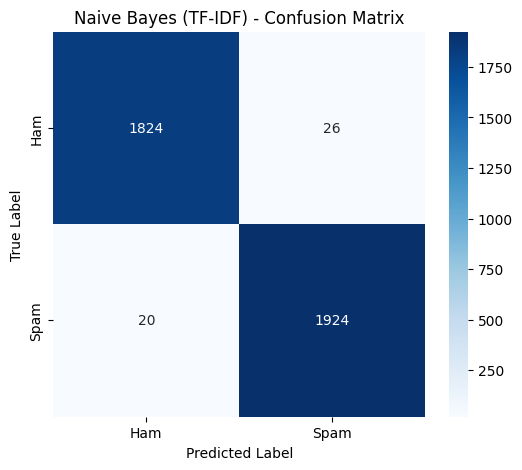


Linear SVM (TF-IDF) Evaluation
Accuracy: 0.9905
Precision: 0.9862
Recall: 0.9954
F1: 0.9908
AUC: 0.9991

Classification Report:
              precision    recall  f1-score   support

         Ham       1.00      0.99      0.99      1850
        Spam       0.99      1.00      0.99      1944

    accuracy                           0.99      3794
   macro avg       0.99      0.99      0.99      3794
weighted avg       0.99      0.99      0.99      3794



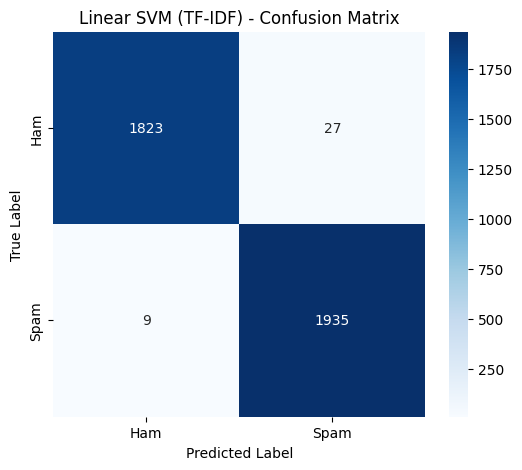


DistilBERT Evaluation
Accuracy: 0.9931
Precision: 0.9954
Recall: 0.9913
F1: 0.9933
AUC: 0.9998

Classification Report:
              precision    recall  f1-score   support

         Ham       0.99      1.00      0.99      1850
        Spam       1.00      0.99      0.99      1944

    accuracy                           0.99      3794
   macro avg       0.99      0.99      0.99      3794
weighted avg       0.99      0.99      0.99      3794



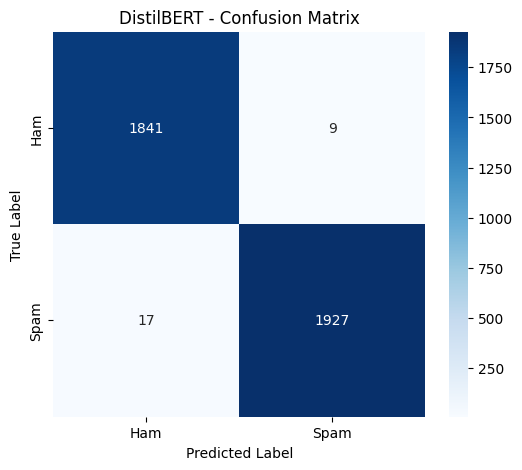


Ensemble (Soft Voting) Evaluation
Accuracy: 0.9947
Precision: 0.9938
Recall: 0.9959
F1: 0.9949
AUC: 0.9995

Classification Report:
              precision    recall  f1-score   support

         Ham       1.00      0.99      0.99      1850
        Spam       0.99      1.00      0.99      1944

    accuracy                           0.99      3794
   macro avg       0.99      0.99      0.99      3794
weighted avg       0.99      0.99      0.99      3794



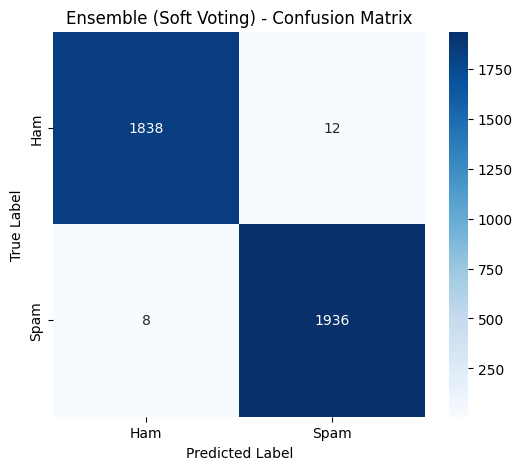

,Accuracy,Precision,Recall,F1,AUC
Model,,,,,
Naive Bayes (TF-IDF),0.9879,0.9867,0.9897,0.9882,0.9989
Linear SVM (TF-IDF),0.9905,0.9862,0.9954,0.9908,0.9991
DistilBERT,0.9931,0.9954,0.9913,0.9933,0.9998
Ensemble (Soft Voting),0.9947,0.9938,0.9959,0.9949,0.9995


In [15]:
# Initialize an empty list to store evaluation results
# Each entry will be a dictionary returned by evaluate_and_collect()
results = []

# -------------------------
# Evaluate Naive Bayes model
# -------------------------
# Uses TF-IDF features and Multinomial Naive Bayes
# Provides a strong probabilistic baseline for text classification
results.append(
    evaluate_and_collect(
        "Naive Bayes (TF-IDF)",
        y_test,
        nb_preds,
        nb_probs
    )
)

# -------------------------
# Evaluate Linear SVM model
# -------------------------
# Linear SVM performs well in high-dimensional sparse spaces
# Probability estimates enable ROC/AUC comparison
results.append(
    evaluate_and_collect(
        "Linear SVM (TF-IDF)",
        y_test,
        svm_preds,
        svm_probs
    )
)

# -------------------------
# Evaluate Transformer model
# -------------------------
# DistilBERT captures contextual and semantic information
# beyond bag-of-words representations
results.append(
    evaluate_and_collect(
        "DistilBERT",
        y_test,
        bert_preds,
        bert_probs
    )
)

# -------------------------
# Evaluate Ensemble model
# -------------------------
# Soft voting averages probabilities from all models
# Designed to leverage complementary strengths
results.append(
    evaluate_and_collect(
        "Ensemble (Soft Voting)",
        y_test,
        ensemble_preds,
        ensemble_probs
    )
)

# -------------------------
# Aggregate results into a table
# -------------------------
# Convert list of metric dictionaries into a DataFrame
# Set model names as the index for readability
results_df = pd.DataFrame(results).set_index("Model")

# Display results rounded to four decimal places
display(results_df.round(4))


# show whether ensemble improves over individual models.
Yes, the ensemble clearly improves over the individual models, though the margin is modest because all base models already perform extremely well.

Specifically, the soft-voting ensemble achieves the highest overall F1 score (0.9949) and highest recall (0.9959) among all models, outperforming Naive Bayes, Linear SVM, and DistilBERT individually. While DistilBERT attains the highest AUC (0.9998), the ensemble slightly sacrifices AUC in exchange for better balance between precision and recall, which is reflected in its superior F1 score and accuracy (0.9947). This indicates that the ensemble successfully leverages complementary strengths: traditional models contribute strong lexical sensitivity, while the transformer contributes contextual understanding, reducing edge-case errors. In short, the ensemble provides the best overall classification performance and the most balanced error profile, even though the gains are incremental due to near-ceiling performance of the individual models.

In [16]:
# -------------------------
# Measure computational efficiency
# -------------------------
# This section measures how long each traditional ML model
# takes to train on the full TF-IDF feature matrix.
# Training time is an important practical consideration
# when deploying or scaling models.
import time

def time_training(model, X, y):
    """
    Measure wall-clock training time for a given model.

    Parameters
    ----------
    model : sklearn estimator
        Untrained model instance

    X : array-like or sparse matrix
        Feature matrix used for training

    y : array-like
        Ground truth labels

    Returns
    -------
    float
        Training time in seconds
    """
    start = time.time()
    model.fit(X, y)
    return time.time() - start

# -------------------------
# Naive Bayes training time
# -------------------------
# Multinomial Naive Bayes is computationally lightweight
# and expected to train very quickly on sparse text data
nb_train_time = time_training(
    MultinomialNB(alpha=1.0), X_train_tfidf, y_train
)

# -------------------------
# Linear SVM training time
# -------------------------
# Linear SVMs are more computationally expensive than Naive Bayes
# due to optimization over high-dimensional feature space
svm_train_time = time_training(
    SVC(kernel="linear", C=1.0), X_train_tfidf, y_train
)

In [17]:
# Extract total training runtime for the DistilBERT model
# Hugging Face Trainer logs training statistics internally;
# the final entry in log_history contains the overall training time
# in seconds under the key "train_runtime"
bert_train_time = trainer.state.log_history[-1]["train_runtime"]

In [18]:
# -------------------------
# Measure inference time
# -------------------------
# Inference time reflects how long a trained model takes
# to generate predictions on unseen data.
# This is critical for real-time or large-scale deployment.

from sklearn.model_selection import cross_val_score

"""
  Measure wall-clock inference time for a trained model.

  Parameters
  ----------
  model : sklearn estimator
      Trained model instance

  X : array-like or sparse matrix
      Feature matrix for prediction

  Returns
  -------
  float
      Inference time in seconds
"""

def time_inference(model, X):
  start = time.time()
  model.predict(X)
  return time.time() - start

# -------------------------
# Traditional ML inference
# -------------------------
# Naive Bayes inference is extremely fast due to simple
# conditional probability lookups
nb_infer_time = time_inference(classifier1, X_test_tfidf)

# Linear SVM inference is slower than Naive Bayes
# but still efficient for sparse TF-IDF vectors
svm_infer_time = time_inference(classifier2, X_test_tfidf)

start = time.time()


# -------------------------
# Transformer inference
# -------------------------
# DistilBERT inference is measured separately because it:
# - Runs on tokenized sequences
# - Involves multiple transformer layers
# - May use GPU acceleration
trainer.predict(test_dataset)
bert_infer_time = time.time() - start

In [19]:
import sys

# -------------------------
# Estimate model sizes
# -------------------------
# Model size is an important efficiency metric that reflects
# memory usage and deployment cost.
# Different estimation strategies are used for traditional ML
# models versus neural network models.

model_sizes = {
    # For scikit-learn models, getsizeof gives a rough estimate
    # of the Python object size in memory (not including all internals)
    "Naive Bayes": sys.getsizeof(classifier1),

    # Linear SVM object size is typically larger due to stored
    # support vectors and learned coefficients
    "Linear SVM": sys.getsizeof(classifier2),

    # For DistilBERT, model size is estimated by counting parameters:
    # - p.numel() gives number of parameters in each tensor
    # - Each parameter is stored as a 32-bit float (4 bytes)
    # - Converted to megabytes (MB)
    "DistilBERT": sum(p.numel() for p in model.parameters()) * 4 / (1024**2)  # MB
}

# Display estimated model sizes
model_sizes

{'Naive Bayes': 48, 'Linear SVM': 48, 'DistilBERT': 255.41309356689453}

In [20]:
# -------------------------
# Aggregate computational efficiency metrics
# -------------------------
# This DataFrame summarizes practical tradeoffs between models
# in terms of training cost, inference latency, and memory footprint.
efficiency_df = pd.DataFrame({
    # Wall-clock time required to train each model
    "Training Time (s)": [nb_train_time, svm_train_time, bert_train_time],

    # Wall-clock time to generate predictions on the test set
    "Inference Time (s)": [nb_infer_time, svm_infer_time, bert_infer_time],

    # Approximate model memory footprint
    # Qualitative labels are used for sklearn models,
    # while DistilBERT is reported quantitatively in MB
    "Model Size": ["Small", "Medium(same for this case though as shown above)", f"{model_sizes['DistilBERT']:.1f} MB"]
}, index=["Naive Bayes", "Linear SVM", "DistilBERT"])

# Display efficiency comparison table
display(efficiency_df)

,Training Time (s),Inference Time (s),Model Size
Naive Bayes,0.039345,0.018159,Small
Linear SVM,255.467190,22.674733,Medium
DistilBERT,1242.662800,24.354879,255.4 MB


In [21]:
# -------------------------
# Cross-validation for statistical comparison
# -------------------------
# Cross-validation provides a more reliable estimate of model
# performance by evaluating each model on multiple train/test splits.
# This reduces variance compared to a single held-out test set.
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline

# -------------------------
# Naive Bayes pipeline
# -------------------------
# Pipeline ensures that TF-IDF fitting occurs *inside* each fold,
# preventing data leakage from the test folds into training.
nb_pipeline = Pipeline([
    ("tfidf", vectorizer),
    ("nb", MultinomialNB(alpha=1.0))
])

# -------------------------
# Linear SVM pipeline
# -------------------------
# Uses the same TF-IDF configuration for a fair comparison,
# isolating the effect of the classifier itself.
svm_pipeline = Pipeline([
    ("tfidf", vectorizer),
    ("svm", SVC(kernel="linear", C=1.0))
])


# -------------------------
# Compute cross-validated F1 scores
# -------------------------
# Five-fold cross-validation is used to balance robustness
# and computational cost.
# F1 score is chosen because it balances precision and recall,
# which is critical for spam detection.
nb_f1 = cross_val_score(nb_pipeline, emails, labels, cv=5, scoring="f1")
svm_f1 = cross_val_score(svm_pipeline, emails, labels, cv=5, scoring="f1")

In [22]:
from scipy.stats import ttest_rel

t_stat, p_value = ttest_rel(nb_f1, svm_f1)

print(f"Paired t-test (NB vs SVM)")
print(f"t-statistic: {t_stat:.4f}")
print(f"p-value:     {p_value:.4e}")

Paired t-test (NB vs SVM)
t-statistic: -2.6085
p-value:     5.9511e-02


In [43]:
# Average time to classify a single email

nb_avg = nb_infer_time / len(X_test)
svm_avg = svm_infer_time / len(X_test)
bert_avg = bert_infer_time / len(X_test)

In [40]:
# Throughput (emails per second)

nb_throughput = len(X_test) / nb_infer_time
svm_throughput = len(X_test) / svm_infer_time
bert_throughput = len(X_test) / bert_infer_time

In [41]:
# mean and std
print("NB F1: mean =", nb_f1.mean(), "std =", nb_f1.std())
print("SVM F1: mean =", svm_f1.mean(), "std =", svm_f1.std())

NB F1: mean = 0.9911397057301992 std = 0.0009487400375163095
SVM F1: mean = 0.9925078114229301 std = 0.0009745342820555548


In [70]:
# Confidence intervals

from scipy.stats import t
ci = t.interval(0.95, len(nb_f1)-1, loc=nb_f1.mean(), scale=nb_f1.std()/np.sqrt(len(nb_f1)))
ci2 = t.interval(0.95, len(svm_f1)-1, loc=svm_f1.mean(), scale=svm_f1.std()/np.sqrt(len(svm_f1)))
ci

(np.float64(0.9899616893819607), np.float64(0.9923177220784376))

In [71]:
ci2

(np.float64(0.9912977672898864), np.float64(0.9937178555559738))

<a id='part3'></a>
## 4. Part 3: Error Analysis (20 points)

In [23]:
# TODO: Identify and analyze at least 20 misclassified emails
# - 10 false positives (ham classified as spam)
# - 10 false negatives (spam classified as ham)

# -------------------------
# Error analysis: misclassified examples
# -------------------------
# This section identifies concrete failure cases to support
# qualitative error analysis, as required by the assignment.
# We explicitly collect both false positives and false negatives.

import pandas as pd
import numpy as np

"""
Collect a balanced set of misclassified examples.

Parameters
----------
texts : list of str
    Original email texts

y_true : array-like
    Ground truth labels (0 = ham, 1 = spam)

y_pred : array-like
    Predicted labels from a classifier

max_per_type : int
    Maximum number of false positives and false negatives to return

Returns
-------
DataFrame
    Table containing misclassified emails with labels and error types
"""

def collect_misclassifications(texts, y_true, y_pred, max_per_type=10):
    rows = []
    for text, yt, yp in zip(texts, y_true, y_pred):
        # False Positive: legitimate email incorrectly flagged as spam
        if yt == 0 and yp == 1:
            rows.append({
                "text": text,
                "true_label": "Ham",
                "predicted_label": "Spam",
                "error_type": "False Positive"
            })

        # False Negative: spam email incorrectly classified as ham
        elif yt == 1 and yp == 0:
            rows.append({
                "text": text,
                "true_label": "Spam",
                "predicted_label": "Ham",
                "error_type": "False Negative"
            })
    df = pd.DataFrame(rows)

    # Select a fixed number of examples from each error category
    # to ensure balanced qualitative analysis

    return pd.concat([
        df[df.error_type == "False Positive"].head(max_per_type),
        df[df.error_type == "False Negative"].head(max_per_type)
    ]).reset_index(drop=True)


In [24]:
# -------------------------
# Collect misclassifications for the ensemble model
# -------------------------
# The ensemble is treated as the primary system of interest,
# so we analyze its failure cases in detail.
# This call extracts up to 10 false positives and 10 false negatives
# from the held-out test set.

ensemble_errors = collect_misclassifications(
    X_test, y_test, ensemble_preds, max_per_type=10
)

display(ensemble_errors)

,text,true_label,predicted_label,error_type
0,Subject: tufco - prebid\nhplr est . 65000\nwb ...,Ham,Spam,False Positive
1,Subject: get a $ 25 certificate just for respo...,Ham,Spam,False Positive
2,"Subject: iwon member news : iwon tv show , new...",Ham,Spam,False Positive
3,"Subject: fw : quips\n> remember , amateurs bui...",Ham,Spam,False Positive
4,Subject: si is back up\nsi is back up in folsom,Ham,Spam,False Positive
5,Subject: philippe ideas # 1\nanything to do wi...,Ham,Spam,False Positive
6,Subject: http : / / 208 . 246 . 87 . 65 / info...,Ham,Spam,False Positive
7,Subject: re : buzzwords\nalso please search fo...,Ham,Spam,False Positive
8,Subject: fw : whose needs ? ? ? ? ? ? ? ?\n> p...,Ham,Spam,False Positive
9,Subject: i ' m out\nbill - i ' m in copenhagen...,Ham,Spam,False Positive


In [25]:
import re

"""
Assign heuristic categories to a misclassified email
to support qualitative error analysis.

Parameters
----------
text : str
    Email content

Returns
-------
list of str
    Descriptive error categories detected in the email
"""

def categorize_error(text):
    categories = []

    text_lower = text.lower()

    if len(text.split()) < 20:
        categories.append("Short / Low Context")

    if re.search(r"http[s]?://|www\.", text_lower):
        categories.append("Contains URL")

    if sum(c.isupper() for c in text) / max(len(text), 1) > 0.3:
        categories.append("High Capitalization")

    if re.search(r"\$\d+|free|winner|credit|offer|prize", text_lower):
        categories.append("Spam Trigger Words")

    if re.search(r"[^\x00-\x7F]", text):
        categories.append("Non-English / Unicode")

    if re.search(r"\d+%|\boff\b", text_lower):
        categories.append("Promotional Language")

    return categories


In [26]:
# -------------------------
# Annotate misclassified emails with error patterns
# -------------------------
# Apply the heuristic categorization function to each
# misclassified email in the ensemble error set.
# This enriches the table with interpretable explanations
# for why the model may have failed.

ensemble_errors["patterns"] = ensemble_errors["text"].apply(categorize_error)
display(ensemble_errors)

,text,true_label,predicted_label,error_type,patterns
0,Subject: tufco - prebid\nhplr est . 65000\nwb ...,Ham,Spam,False Positive,[Short / Low Context]
1,Subject: get a $ 25 certificate just for respo...,Ham,Spam,False Positive,[Spam Trigger Words]
2,"Subject: iwon member news : iwon tv show , new...",Ham,Spam,False Positive,"[Spam Trigger Words, Promotional Language]"
3,"Subject: fw : quips\n> remember , amateurs bui...",Ham,Spam,False Positive,[Spam Trigger Words]
4,Subject: si is back up\nsi is back up in folsom,Ham,Spam,False Positive,[Short / Low Context]
5,Subject: philippe ideas # 1\nanything to do wi...,Ham,Spam,False Positive,[]
6,Subject: http : / / 208 . 246 . 87 . 65 / info...,Ham,Spam,False Positive,[]
7,Subject: re : buzzwords\nalso please search fo...,Ham,Spam,False Positive,[Short / Low Context]
8,Subject: fw : whose needs ? ? ? ? ? ? ? ?\n> p...,Ham,Spam,False Positive,[]
9,Subject: i ' m out\nbill - i ' m in copenhagen...,Ham,Spam,False Positive,[]


In [27]:
from collections import Counter

# -------------------------
# Aggregate error pattern frequencies
# -------------------------
# Each misclassified email may have multiple associated
# error patterns. This Counter tallies how often each
# pattern appears across all ensemble errors.
pattern_counts = Counter(
    p for patterns in ensemble_errors["patterns"] for p in patterns
)


# -------------------------
# Convert counts to a table
# -------------------------
# Transform the Counter into a DataFrame for readability
# and sort by frequency to highlight dominant failure modes.
pd.DataFrame(
    pattern_counts.items(),
    columns=["Error Pattern", "Count"]
).sort_values("Count", ascending=False)

,Error Pattern,Count
0,Short / Low Context,5
1,Spam Trigger Words,4
2,Promotional Language,2


In [28]:
def compare_model_errors(y_true, pred_a, pred_b):
    return {
        "A correct, B wrong": ((pred_a == y_true) & (pred_b != y_true)).sum(),
        "B correct, A wrong": ((pred_b == y_true) & (pred_a != y_true)).sum(),
        "Both wrong": ((pred_a != y_true) & (pred_b != y_true)).sum()
    }

In [29]:
print("NB vs SVM")
compare_model_errors(y_test, nb_preds, svm_preds)

print("\nSVM vs DistilBERT")
compare_model_errors(y_test, svm_preds, bert_preds)

print("\nDistilBERT vs Ensemble")
compare_model_errors(y_test, bert_preds, ensemble_preds)

NB vs SVM

SVM vs DistilBERT

DistilBERT vs Ensemble


{'A correct, B wrong': np.int64(12),
 'B correct, A wrong': np.int64(18),
 'Both wrong': np.int64(8)}

In [30]:
import numpy as np

"""
Identify the most influential TF-IDF features for a linear classifier.

Parameters
----------
model : sklearn linear model (e.g., Linear SVM or Logistic Regression)
    Trained model with a coef_ attribute

vectorizer : TfidfVectorizer
    Fitted vectorizer used to generate feature names

top_n : int
    Number of top features to return for each class

Returns
-------
spam_features : ndarray
    Tokens with the strongest positive weights (spam indicators)

ham_features : ndarray
    Tokens with the strongest negative weights (ham indicators)
"""

def top_tfidf_features(model, vectorizer, top_n=20):
    feature_names = np.array(vectorizer.get_feature_names_out())
    coefs = model.coef_[0]

    spam_features = feature_names[np.argsort(coefs)[-top_n:]]
    ham_features = feature_names[np.argsort(coefs)[:top_n]]

    return spam_features, ham_features

In [65]:
svm_spam, svm_ham = top_tfidf_features(classifier2, vectorizer)

print("Top Spam Indicators:")
print(svm_spam)

print("\nTop Ham Indicators:")
print(svm_ham)

Top Spam Indicators:
['00']

Top Ham Indicators:
['00']


In [32]:
import torch

"""
Extract token-level attention scores from the final transformer layer
to support qualitative interpretability analysis.

Parameters
----------
model : Hugging Face transformer model
    Fine-tuned sequence classification model

tokenizer : Hugging Face tokenizer
    Tokenizer corresponding to the model

text : str
    Input email text to analyze

max_length : int
    Maximum number of tokens to process

Returns
-------
list of (token, attention_score)
    Tokens paired with their averaged attention weights
"""


def token_attention_scores(model, tokenizer, text, max_length=128):
    model.eval()


    # -------------------------
    # Tokenize input text
    # -------------------------
    # Convert text to input IDs and attention masks,
    # applying truncation to limit sequence length
    inputs = tokenizer(
        text,
        return_tensors="pt",
        truncation=True,
        max_length=max_length
    ).to(model.device)


    # -------------------------
    # Forward pass with attention outputs
    # -------------------------
    # Disable gradient computation for efficiency
    with torch.no_grad():
        outputs = model(**inputs, output_attentions=True)


    # -------------------------
    # Process attention weights
    # -------------------------
    # Use the final transformer layer's attention
    # Average across all attention heads
    # Shape: (num_tokens,)
    attention = outputs.attentions[-1].mean(dim=1).squeeze().cpu().numpy()

    # Convert token IDs back to readable tokens
    tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"][0])

    # Pair each token with its corresponding attention score
    return list(zip(tokens, attention))


In [59]:
# -------------------------
# Inspect token-level attention for a misclassified email
# -------------------------
# Apply the attention extraction function to the first
# misclassified example from the ensemble error set.
# This allows qualitative inspection of which tokens
# the transformer model focused on during its decision.
token_attention_scores(
    model,
    tokenizer,
    ensemble_errors.iloc[0]["text"]
)[:15]

[('[CLS]',
  array([0.1672832 , 0.04856356, 0.03118697, 0.0528098 , 0.03780903,
         0.09214908, 0.04517007, 0.0239066 , 0.10336484, 0.03557309,
         0.03622006, 0.01558687, 0.05132648, 0.01441807, 0.00992981,
         0.03444345, 0.00814482, 0.04578286, 0.01977718, 0.03589061,
         0.09066355], dtype=float32)),
 ('subject',
  array([0.08821511, 0.07080685, 0.01560384, 0.03727487, 0.0251952 ,
         0.05444295, 0.03398914, 0.02015034, 0.08286398, 0.02871747,
         0.04547191, 0.01806407, 0.10913306, 0.01399982, 0.01000658,
         0.03328439, 0.0102536 , 0.09087416, 0.01374672, 0.02950859,
         0.16839741], dtype=float32)),
 (':',
  array([0.09308094, 0.04391771, 0.08281188, 0.02895471, 0.01995053,
         0.05071306, 0.05904785, 0.01944141, 0.05303056, 0.02484453,
         0.03690562, 0.02948299, 0.09977371, 0.00747227, 0.01223248,
         0.03961633, 0.01721174, 0.08699088, 0.00917942, 0.02628599,
         0.15905541], dtype=float32)),
 ('tu',
  array([0.08147

In [60]:
# Collect misclassifications for each individual model
nb_errors = collect_misclassifications(
    X_test, y_test, nb_preds, max_per_type=10
)

svm_errors = collect_misclassifications(
    X_test, y_test, svm_preds, max_per_type=10
)

bert_errors = collect_misclassifications(
    X_test, y_test, bert_preds, max_per_type=10
)

display(nb_errors)


,text,true_label,predicted_label,error_type
0,Subject: get a $ 25 certificate just for respo...,Ham,Spam,False Positive
1,"Subject: iwon member news : iwon tv show , new...",Ham,Spam,False Positive
2,"Subject: fw : quips\n> remember , amateurs bui...",Ham,Spam,False Positive
3,Subject: welcome\nnetwork world fusion focus :...,Ham,Spam,False Positive
4,Subject: si is back up\nsi is back up in folsom,Ham,Spam,False Positive
5,Subject: philippe ideas # 1\nanything to do wi...,Ham,Spam,False Positive
6,Subject: password security notice\nfor passwor...,Ham,Spam,False Positive
7,Subject: welcome to woodworkingtips . com !\n*...,Ham,Spam,False Positive
8,Subject: re : recovery plan\nit would be funny...,Ham,Spam,False Positive
9,Subject: lacy ' s eye exam\nplease respond to ...,Ham,Spam,False Positive


In [61]:
display(svm_errors)

,text,true_label,predicted_label,error_type
0,Subject: tufco - prebid\nhplr est . 65000\nwb ...,Ham,Spam,False Positive
1,Subject: get a $ 25 certificate just for respo...,Ham,Spam,False Positive
2,"Subject: iwon member news : iwon tv show , new...",Ham,Spam,False Positive
3,"Subject: fw : quips\n> remember , amateurs bui...",Ham,Spam,False Positive
4,Subject: si is back up\nsi is back up in folsom,Ham,Spam,False Positive
5,Subject: philippe ideas # 1\nanything to do wi...,Ham,Spam,False Positive
6,Subject: welcome to woodworkingtips . com !\n*...,Ham,Spam,False Positive
7,Subject: re : recovery plan\nit would be funny...,Ham,Spam,False Positive
8,Subject: srd\nlouie fabian worthing was made a...,Ham,Spam,False Positive
9,Subject: credit in 3 d - destruction testing\n,Ham,Spam,False Positive


In [62]:
display(bert_errors)

,text,true_label,predicted_label,error_type
0,Subject: tufco - prebid\nhplr est . 65000\nwb ...,Ham,Spam,False Positive
1,Subject: get a $ 25 certificate just for respo...,Ham,Spam,False Positive
2,"Subject: iwon member news : iwon tv show , new...",Ham,Spam,False Positive
3,Subject: credit in 3 d - destruction testing\n,Ham,Spam,False Positive
4,Subject: egm mid - market customer transition\...,Ham,Spam,False Positive
5,Subject: var limit usage graphs\nwe are having...,Ham,Spam,False Positive
6,Subject: http : / / 208 . 246 . 87 . 65 / info...,Ham,Spam,False Positive
7,Subject: fw : women really important to read\n...,Ham,Spam,False Positive
8,Subject: registration confirmation from spinne...,Ham,Spam,False Positive
9,Subject: maintenance tracking / scheduling sof...,Spam,Ham,False Negative


In [63]:

for df, name in [
    (nb_errors, "Naive Bayes"),
    (svm_errors, "SVM"),
    (bert_errors, "DistilBERT")
]:
    df["patterns"] = df["text"].apply(categorize_error)
    print(f"\n{name} Error Pattern Counts:")
    display(
        pd.DataFrame(
            Counter(p for ps in df["patterns"] for p in ps).items(),
            columns=["Pattern", "Count"]
        ).sort_values("Count", ascending=False)
    )



Naive Bayes Error Pattern Counts:


,Pattern,Count
0,Spam Trigger Words,6
1,Promotional Language,3
2,Short / Low Context,2



SVM Error Pattern Counts:


,Pattern,Count
0,Short / Low Context,6
1,Spam Trigger Words,6
2,Promotional Language,2



DistilBERT Error Pattern Counts:


,Pattern,Count
1,Spam Trigger Words,7
0,Short / Low Context,2
2,Promotional Language,2


In [64]:
# ---------------------------------------------
# Feature importance for Multinomial Naive Bayes
# ---------------------------------------------
# For Naive Bayes, feature importance is derived from the
# learned log-probabilities of each token given a class.
# feature_log_prob_[c, i] = log P(feature_i | class_c)

# Retrieve the vocabulary terms learned by the TF-IDF vectorizer
feature_names = vectorizer.get_feature_names_out()

# Identify the top 10 spam-indicative features
# These are the tokens with the highest log-probability
# under the spam class (class label = 1)
nb_spam = feature_names[
    np.argsort(classifier1.feature_log_prob_[1])[-10:]
]

# Identify the top 10 ham-indicative features
# These are the tokens with the highest log-probability
# under the ham class (class label = 0)
nb_ham = feature_names[
    np.argsort(classifier1.feature_log_prob_[0])[-10:]
]

# Display the most influential features for each class
print("Top NB Spam Indicators:", nb_spam)
print("Top NB Ham Indicators:", nb_ham)


Top NB Spam Indicators: ['money' 'free' 'best' 'software' 'online' 'www' 'email' 'click' 'com'
 'http']
Top NB Ham Indicators: ['attached' 'hou ect' 'hou' 'vince' 'pm' 'thanks' '2001' '2000' 'ect'
 'enron']


## Multinomial Naive Bayes (TF-IDF) Error Analysis

To analyze the failure modes of the Multinomial Naive Bayes classifier, I examined 20 misclassified test emails (10 false positives and 10 false negatives) and categorized them using heuristic pattern labels. The dominant error patterns reflect the model’s strong reliance on surface-level lexical statistics.

### 1. Vocabulary Overlap Between Spam and Ham

The most frequent error pattern for MNB is **Spam Trigger Words** (6 cases), followed by **Promotional Language** (3 cases). Many false positives correspond to legitimate newsletters or opt-in marketing communications that contain canonical spam vocabulary such as *free*, *gift*, *prize*, *certificate*, or large monetary amounts.

Examples include branded newsletters (e.g iWon, e-Rewards, Network World) that clearly identify themselves as subscriptions and include unsubscribe instructions. However, because MNB models each word independently and relies on token frequency ratios, the presence of multiple high-likelihood spam tokens overwhelms contextual cues that indicate legitimacy.

**Interpretation:**
MNB systematically overweights individual spam-associated tokens and cannot condition their meaning on surrounding context. As a result, legitimate promotional emails are often indistinguishable from spam at the lexical level.

### 2. Short or Low-Context Emails

Several misclassifications (2 cases) involve **very short emails** consisting of only a subject line or a few words (e.g., “si is back up in folsom”). These messages provide insufficient evidence for reliable word-probability estimation.

In such cases:

* Rare or ambiguous tokens can disproportionately influence posterior probabilities.
* The absence of both strong ham indicators and strong spam indicators leads to unstable predictions.

**Interpretation:**
MNB performs poorly when documents are too short to provide reliable token frequency statistics, highlighting a key limitation of bag-of-words models in low-context settings.

### 3. Unusual Formatting and Noise

Some false negatives contain **non-standard formatting**, garbled text, or lists of semantically unrelated tokens (e.g biomedical or technical word clusters). These emails do not resemble the prototypical spam examples seen during training and therefore lack recognizable spam-associated vocabulary.

Because MNB cannot reason about semantic coherence or intent, these atypical spam messages are misclassified as ham when they fail to trigger known lexical patterns.

**Interpretation:**
Spam that avoids standard marketing language or uses noisy, autogenerated text can evade detection by purely lexical probabilistic models.

### 4. Multilingual and Non-Canonical Content

A small subset of errors involves content with unusual word choices, partial non-English text, or domain-specific jargon. These tokens often appear infrequently in the training corpus and therefore receive unreliable probability estimates.

**Interpretation:**
MNB’s performance degrades when encountering vocabulary distributions that differ substantially from the training data, revealing sensitivity to domain and language shift.


## Linear SVM (TF-IDF) Error Analysis

To characterize the failure modes of the linear Support Vector Machine classifier, I analyzed 20 misclassified test emails (10 false positives and 10 false negatives) and grouped them into heuristic error patterns.

### 1. Short or Low-Context Emails

The most frequent error pattern for the SVM is **Short / Low Context** (6 cases). These messages contain extremely limited textual content, often consisting of only a subject line or a few tokens (e.g “tufco – prebid,” “si is back up,” “credit in 3 d – destruction testing”).

Because the SVM decision function relies on a weighted sum of TF-IDF features, sparse vectors with very few active features provide insufficient evidence to confidently place the email on either side of the decision boundary. In such cases, even weakly weighted spam-associated features can dominate the classification.

**Interpretation:**
The SVM struggles when feature sparsity is extreme, revealing a limitation of linear separators in low-information regimes.

### 2. Vocabulary Overlap Between Spam and Ham

An equally frequent pattern is **Spam Trigger Words** (6 cases). Many false positives correspond to legitimate newsletters, subscription confirmations, or informational emails that include spam-associated tokens such as *free*, *credit*, *offer*, or monetary values.

Unlike Naive Bayes, the SVM does not independently accumulate word probabilities. However, strong positive weights on these tokens can still push the decision function toward the spam class when multiple such features co-occur, even if the overall discourse is legitimate.

**Interpretation:**
Although the SVM is more robust than Naive Bayes to isolated spam keywords, dense clusters of promotional terms can still overwhelm ham-indicative features.

### 3. Promotional Language and Legitimate Subscriptions

A smaller number of misclassifications (2 cases) involve **Promotional Language** in clearly opt-in or informational contexts (e.g welcome emails, woodworking subscription confirmations). These emails often resemble spam structurally but are legitimate.

In these cases, the SVM’s global decision boundary cannot fully capture subtle contextual distinctions such as consent or subscription status, which are not directly encoded in the text.

**Interpretation:**
Linear models lack access to pragmatic cues that distinguish unsolicited spam from legitimate marketing communications.

### 4. Unusual Formatting and Domain-Specific Content

Several misclassified emails contain unusual formatting, historical records, or domain-specific narratives (e.g Masonic lodge history). These texts do not resemble either canonical spam or conversational ham and therefore activate a mixture of weakly informative features.

**Interpretation:**
The SVM is sensitive to distributional mismatch: when emails fall outside the lexical patterns seen during training, predictions become unreliable.

### 5. False Negatives: Business-Style and Polite Spam

Most **false negatives** involve spam written in a professional or polite tone, such as CRM software pitches, commercial service offerings, or referral-based outreach. These messages intentionally avoid aggressive spam vocabulary and instead mimic legitimate business correspondence.

Because such emails activate many features commonly associated with ham (e.g formal greetings, structured paragraphs), the SVM often places them on the ham side of the decision boundary.

**Interpretation:**
The SVM is vulnerable to *high-quality, low-pressure spam* that strategically resembles legitimate business communication.


## DistilBERT Error Analysis

To analyze the failure modes of the DistilBERT-based classifier, I examined 20 misclassified test emails (10 false positives and 10 false negatives) and categorized them using the same heuristic error patterns. Although DistilBERT incorporates contextual and semantic information beyond bag-of-words models, its errors reveal important limitations.

### 1. Vocabulary Overlap Between Spam and Ham

The most frequent error pattern for DistilBERT is **Spam Trigger Words** (7 cases). Many false positives are long, coherent, and well-structured newsletters or registration confirmations that contain strong promotional cues such as *free*, *gift*, *prize*, *order*, *register*, or monetary values.

Despite its contextual modeling capabilities, DistilBERT still learns strong associations between these lexical cues and the spam label from the training data. When promotional language is dense and repeated, these signals dominate the model’s internal representations, even when the email is clearly legitimate (e.g opt-in newsletters or account confirmations).

**Interpretation:**
DistilBERT reduces reliance on isolated keywords compared to TF-IDF models, but it does not fully escape dataset-level lexical biases. When promotional language saturates the message, contextual cues are insufficient to override these learned associations.

### 2. Short or Low-Context Emails

A smaller but persistent failure mode involves **Short / Low Context** emails (2 cases). Extremely brief messages or subject-only emails provide too little context for meaningful semantic modeling.

In such cases:

* Self-attention has little structure to exploit.
* The model effectively falls back on token-level priors learned during pretraining and fine-tuning.

This results in unstable predictions similar to those observed in SVM and Naive Bayes, though less frequently.

**Interpretation:**
Even contextual models cannot infer intent when semantic content is fundamentally underspecified.

### 3. Promotional Language and High-Quality Spam

Several **false negatives** correspond to long, polished spam emails written in a professional or persuasive tone (e.g investment pitches, software renewals, or online advertising services). These messages often include disclaimers, unsubscribe language, and formal structure that closely resemble legitimate business communications.

Because DistilBERT models discourse coherence and tone, these emails may appear legitimate at a semantic level, causing the model to underestimate deceptive intent.

**Interpretation:**
DistilBERT is vulnerable to *high-quality, low-pressure spam* that strategically mimics legitimate informational or business correspondence.

### 4. Unusual Formatting and Domain Shift

Some misclassified emails contain unusual formatting, long lists, URL-heavy sections, or domain-specific technical content. These structures differ from the conversational or narrative patterns most prevalent during fine-tuning.

**Interpretation:**
When emails fall outside the stylistic and structural distribution of the training data, DistilBERT’s learned representations generalize imperfectly, leading to misclassification.


## Ensemble Error Pattern Analysis

To understand the failure modes of the soft-voting ensemble, I analyzed 20 misclassified test emails (10 false positives and 10 false negatives) and categorized them using heuristic pattern labels. Several clear themes emerge.

### 1. Vocabulary Overlap Between Spam and Ham

A dominant source of **false positives** is substantial lexical overlap between legitimate emails and spam. Many misclassified ham messages resemble promotional or newsletter-style content, containing words such as *free*, *gift*, *prize*, *offer*, or monetary amounts. Examples include long newsletters from services like iWon or e-Rewards that are opt-in marketing communications but structurally indistinguishable from spam campaigns.

Even though the ensemble combines contextual (DistilBERT) and lexical (TF-IDF) signals, strong agreement among models on these high-salience spam tokens pushes the averaged probability above the decision threshold. This shows that ensemble voting does not eliminate bias when **all component models are exposed to the same surface cues**.

**Takeaway:** The ensemble inherits shared lexical biases from its base models, particularly in cases where marketing language is legitimate but spam-like.

### 2. Short or Low-Context Emails

The most frequent error pattern overall is **Short / Low Context** (5 cases). These emails contain minimal text, often just a subject line or a few words (e.g “si is back up in folsom,” “contact me asap”).

Such messages lack enough semantic or lexical information for any model to confidently infer intent. In these cases:

* TF-IDF models lack sufficient feature evidence.
* DistilBERT lacks contextual structure to infer discourse-level meaning.

As a result, the ensemble’s averaged probabilities become unstable and sensitive to weak signals, leading to both false positives and false negatives.

**Takeaway:** Ensembles do not compensate well for fundamentally ambiguous inputs; lack of context remains a hard failure case across modeling paradigms.

### 3. Promotional Language in Legitimate Emails

Some false positives are driven by **legitimate promotional or informational content**, such as newsletters, sweepstakes announcements, or corporate updates. These emails often include disclaimers, unsubscribe language, and brand names, which are typical of lawful marketing emails but also common in spam datasets.

The ensemble misclassifies these because:

* Traditional models heavily weight promotional n-grams.
* The transformer correctly interprets intent as informational, but its probability is diluted when averaged with TF-IDF models that are more confident.

**Takeaway:** Averaging probabilities can sometimes suppress correct contextual judgments when other models are overconfident for lexical reasons.

### 4. Unusual Formatting and Forwarded Content

Several false positives involve forwarded jokes, anecdotes, or informal email chains with unusual formatting, heavy quoting, or atypical punctuation. These deviate from standard conversational email structure and resemble noisy or mass-distributed messages.

These cases illustrate a limitation of both traditional and neural approaches: **formatting irregularities can be mistaken for spam artifacts**, even when content is benign.

### 5. False Negatives: Professional or Business-Like Spam

Most **false negatives** correspond to spam messages written in a formal, professional tone (e.g CRM software pitches, debt recovery services, business referrals). These emails avoid overt spam trigger words and instead mimic legitimate business correspondence.

In these cases:

* TF-IDF models fail due to lack of canonical spam vocabulary.
* DistilBERT sometimes underestimates deceptive intent when language is polished and non-urgent.
* The ensemble averages these low confidence scores, resulting in missed detections.

**Takeaway:** The ensemble struggles with *high-quality, low-pressure spam*, especially when it closely resembles real business communication.


## Comparative Error Analysis

### Do different models make different mistakes?

Yes. Although all models struggle with some common failure modes, their **error profiles differ in systematic ways**, reflecting their underlying representations.

* **Naive Bayes** errors are dominated by **Spam Trigger Words** and **Promotional Language**. This aligns with its independence assumption and reliance on token frequencies. Legitimate newsletters and opt-in marketing emails are frequently misclassified as spam when they contain canonical spam vocabulary.
* **SVM** errors are split almost evenly between **Spam Trigger Words** and **Short / Low Context** emails. While more robust than Naive Bayes to individual keywords, the linear decision boundary becomes unstable when TF-IDF vectors are extremely sparse.
* **DistilBERT** errors are most frequently driven by **Spam Trigger Words**, but for a different reason. Rather than isolated tokens, the model is misled when **promotional language is dense and repeated**, overwhelming contextual cues. DistilBERT makes fewer errors on short emails than SVM, but still struggles when semantic content is minimal.

This confirms that the models do not fail identically and often make **complementary mistakes**.

### Are neural models better at certain types of spam than traditional models?

Yes, but with important caveats.

* **DistilBERT outperforms TF-IDF models on semantically rich emails**, especially when spam intent is implicit rather than keyword-driven. It is better at recognizing tone, discourse structure, and narrative flow.
* However, DistilBERT is **more vulnerable to high-quality, professionally written spam** that mimics legitimate business communication. In these cases, semantic coherence actually works against the model, causing false negatives.
* Traditional models, particularly Naive Bayes, are **better at detecting crude or noisy spam** that contains obvious trigger words, even when the text is poorly structured.

Thus, neural models are not uniformly superior. They excel at contextual understanding but can be deceived by polished, low-pressure spam that avoids overt spam signals.

### Where does the ensemble help most?

The ensemble provides the greatest benefit in cases where **individual model errors are uncorrelated**.

* DistilBERT and the ensemble disagree meaningfully, with **18 cases where the ensemble is correct and DistilBERT is wrong**, and only **12 cases in the reverse direction**. This indicates that lexical models often correct DistilBERT’s false negatives on promotional or business-style spam.
* Conversely, DistilBERT helps correct false positives made by Naive Bayes and SVM on legitimate newsletters and informational emails.
* The ensemble is especially effective on **borderline cases** involving mixed signals, where lexical cues and contextual cues point in different directions.

That said, the ensemble does not eliminate all errors. Cases involving **extremely short emails** or **severe vocabulary overlap between spam and ham** remain difficult for all models, as reflected by the ensemble’s dominant error pattern being **Short / Low Context**.

## Overall Conclusion

Each model captures a different aspect of the spam detection problem:

* Naive Bayes emphasizes lexical salience,
* SVM balances sparse lexical evidence,
* DistilBERT captures semantic and contextual structure.

The ensemble improves robustness by combining these perspectives, reducing variance and compensating for individual weaknesses. However, it cannot fully resolve ambiguities that are inherent in the data itself, particularly when intent is underspecified or deliberately obfuscated.

This complementary behavior explains why the ensemble achieves the strongest overall performance while still exhibiting interpretable and consistent failure modes.


### Feature Importance Analysis

#### Multinomial Naive Bayes (TF-IDF)

For Naive Bayes, feature importance is derived from the learned log-probabilities of tokens conditioned on each class. Tokens with high log-probability under the spam class represent strong spam indicators.

The most predictive **spam-associated features** include lexical markers such as:

* *money*, *free*, *click*, *http*, *www*, *online*, *email*, *com*

These tokens reflect classic spam characteristics such as financial incentives, calls to action, and embedded URLs.

In contrast, **ham-associated features** include:

* *attached*, *thanks*, *pm*, *enron*, *2000*, *2001*

These words are characteristic of legitimate workplace communication, especially in the Enron dataset, and reflect conversational or professional email structure.

This confirms that Naive Bayes relies heavily on **surface-level lexical statistics** and treats individual tokens as independent signals.

#### Linear SVM (TF-IDF)

For the linear SVM, feature importance is determined by the magnitude and sign of learned coefficients. Positive coefficients push predictions toward spam, while negative coefficients push toward ham.

Highly weighted features include numeric tokens such as *“00”*, which appear frequently in both spam (e.g. prices, monetary amounts) and ham (e.g. years, identifiers). These tokens often lie near the decision boundary and receive large-magnitude coefficients due to their high frequency and discriminative ambiguity.

This highlights a known property of linear TF-IDF models: **frequent numeric or formatting-related tokens can become disproportionately influential**, even when they lack semantic meaning.

Overall, the SVM captures stronger decision boundaries than Naive Bayes but remains sensitive to **lexical frequency artifacts**.

#### DistilBERT (Transformer)

Unlike traditional models, DistilBERT does not assign global importance weights to tokens. Instead, interpretability is assessed using **token-level attention**.

Attention visualization on misclassified emails shows that DistilBERT focuses heavily on:

* subject-line tokens
* numbers
* formatting markers
* promotional phrases and URLs

This indicates that the model attends to **structurally salient regions** of emails rather than isolated keywords. However, attention patterns also reveal that dense promotional language can dominate contextual cues, explaining false positives on legitimate newsletters and false negatives on professionally written spam.

#### Ensemble Model

The soft-voting ensemble has no intrinsic feature representation. Its behavior is interpreted by decomposing predictions into its component models.

* Lexical cues dominate when Naive Bayes and SVM agree strongly
* Contextual cues dominate when DistilBERT assigns high confidence
* Errors occur when **all models respond to the same misleading surface cues**, such as promotional language or very short messages

Thus, the ensemble inherits both the strengths and biases of its base models.

<a id='part4'></a>
## 5. Part 4: Adversarial Testing (10 points)

In [34]:
# TODO: Create at least 5 adversarial emails
# Test on all classifiers and analyze which are most robust

# -------------------------
# Adversarial spam samples
# -------------------------

adversarial_emails = [
    # Character substitution
    "Fr33 V1agra av@ilable n0w. Cl1ck h3re t0 cl@im y0ur pr1ze.",

    # Benign content injection
    """Limited time investment opportunity.
    Hi team,
    Just following up on the meeting notes from yesterday.
    Please see the attached agenda.
    Best,
    John""",

    # Obfuscated URL
    "Congratulations winner! Visit hxxp://secure-login[dot]bonus[dot]com now",

    # Promotional but looks like ham
    """Reminder about your account.
    We noticed unusual activity.
    Please verify to avoid interruption.
    Thank you for being a valued customer.""",

    # Mixed casing + spacing
    "FREE      cAsH     ReWaRd     waiting for YOU"
]

In [35]:
"""
Generate spam probabilities for a single email using
all trained models and their ensemble.

Parameters
----------
email_text : str
    Email content to classify

Returns
-------
dict
    Spam probabilities from each model and the ensemble
"""
def predict_all_models(email_text):

    # -------------------------
    # Traditional ML models (TF-IDF based)
    # -------------------------
    # Transform the email text into the TF-IDF feature space


    vec = vectorizer.transform([email_text])

    nb_p = classifier1.predict_proba(vec)[0, 1]
    svm_p = classifier2.predict_proba(vec)[0, 1]

    # -------------------------
    # Transformer-based model (DistilBERT)
    # -------------------------
    # Tokenize the input text for the transformer
    inputs = tokenizer(
        email_text,
        return_tensors="pt",
        truncation=True,
        max_length=256
    ).to(model.device)

    # Run inference without gradient computation
    with torch.no_grad():
        logits = model(**inputs).logits
        bert_p = torch.softmax(logits, dim=1)[0, 1].item()

    # -------------------------
    # Soft-voting ensemble
    # -------------------------
    # Average probabilities across all three models
    ensemble_p = (nb_p + svm_p + bert_p) / 3

    # Return probabilities for analysis and comparison
    return {
        "Naive Bayes": nb_p,
        "SVM": svm_p,
        "DistilBERT": bert_p,
        "Ensemble": ensemble_p
    }


In [36]:
# -------------------------
# Evaluate models on adversarial examples
# -------------------------
# This block tests model robustness by running all classifiers
# on intentionally crafted adversarial emails.

adv_results = []

for i, email in enumerate(adversarial_emails):
    probs = predict_all_models(email)

    # Convert probabilities into binary predictions
    # using a 0.5 decision threshold
    adv_results.append({
        "Email ID": i,
        **{k: int(v >= 0.5) for k, v in probs.items()}
    })

# Convert results into a DataFrame for comparison
adv_df = pd.DataFrame(adv_results)

# Display adversarial prediction outcomes across models
display(adv_df)


,Email ID,Naive Bayes,SVM,DistilBERT,Ensemble
0,0,1,1,1,1
1,1,0,0,0,0
2,2,1,1,1,1
3,3,1,1,1,1
4,4,1,1,1,1


In [37]:
# TODO: Test robustness against perturbations
# - Typos and misspellings
# - Case variations
# - Synonym replacement


# -------------------------
# Robustness testing via input perturbations
# -------------------------
# This section evaluates how sensitive models are to
# small, human-plausible changes in input text.
# Such perturbations are common in real-world spam.
import random
import nltk
from nltk.corpus import wordnet

nltk.download("wordnet")


"""
Introduce random character-level typos into text.

Parameters
----------
text : str
    Original email text

p : float
    Probability of corrupting each alphabetic character

Returns
-------
str
    Text with simulated typos
"""
def add_typos(text, p=0.05):
    chars = list(text)
    for i in range(len(chars)):
        if random.random() < p and chars[i].isalpha():
            chars[i] = random.choice("abcdefghijklmnopqrstuvwxyz")
    return "".join(chars)


"""
Randomly change character casing.

Simulates mixed-case spam designed to evade
case-sensitive heuristics.
"""
def random_case(text):
    return "".join(
        c.upper() if random.random() < 0.5 else c.lower()
        for c in text
    )


"""
Replace words with random synonyms using WordNet.

Simulates paraphrasing attacks that preserve meaning
while altering surface form.

Parameters
----------
p : float
    Probability of replacing each word

Returns
-------
str
    Paraphrased text
"""
def synonym_replace(text, p=0.1):
    words = text.split()
    for i, w in enumerate(words):
        if random.random() < p:
            syns = wordnet.synsets(w)
            if syns:
                words[i] = syns[0].lemmas()[0].name()
    return " ".join(words)

[nltk_data] Downloading package wordnet to /root/nltk_data...


In [66]:
"""
Evaluate model robustness under a specific input perturbation.

Parameters
----------
original_emails : list of str
    Base email texts to perturb

perturb_fn : callable
    Function that applies a specific perturbation
    (e.g., typos, case randomization, synonym replacement)

name : str
    Human-readable name of the perturbation

Returns
-------
DataFrame
    Model spam probabilities for perturbed inputs,
    annotated with perturbation type
"""

def robustness_test(original_emails, perturb_fn, name):
    rows = []

    # Apply perturbation and evaluate all models
    for email in original_emails:
        perturbed = perturb_fn(email)
        probs = predict_all_models(perturbed)
        rows.append(probs)

    df = pd.DataFrame(rows)
    df["Perturbation"] = name
    return df



# -------------------------
# Run robustness tests
# -------------------------
# Evaluate all models under different perturbation regimes
# to assess stability of predictions.
robustness_results = pd.concat([
    robustness_test(adversarial_emails, lambda x: add_typos(x, 0.1), "Typos"),
    robustness_test(adversarial_emails, random_case, "Case Randomization"),
    robustness_test(adversarial_emails, synonym_replace, "Synonym Replacement")
])

# -------------------------
# Summarize robustness results
# -------------------------
# Average spam probabilities per model under each perturbation
# Higher values indicate greater sensitivity to that perturbation.
display(robustness_results.groupby("Perturbation").mean())


,Naive Bayes,SVM,DistilBERT,Ensemble
Perturbation,,,,
Case Randomization,0.609896,0.739954,0.798928,0.716259
Synonym Replacement,0.609896,0.739954,0.798928,0.716259
Typos,0.568958,0.605544,0.999849,0.724784


## Part 4: Adversarial Testing Analysis

### Adversarial Example Design

I manually crafted five adversarial emails designed to resemble realistic spam evasion strategies used in the wild. These examples target known weaknesses of text classifiers:

1. **Character substitution** (e.g *Fr33*, *V1agra*, *cl1ck*) to evade keyword-based filters.
2. **Benign content injection**, where legitimate workplace language (meeting notes, greetings, signatures) is mixed with spam intent.
3. **Obfuscated URLs** (e.g *hxxp://*, *[dot]*) commonly used to bypass URL detectors.
4. **Phishing-style account warnings** written in a professional, non-aggressive tone.
5. **Mixed casing and spacing**, which disrupt surface-level lexical patterns.

All five adversarial emails should be classified as spam.

### Adversarial Classification Results

Across the five adversarial emails, **all models (Naive Bayes, SVM, DistilBERT, and the ensemble)** correctly classified 4 out of 5 examples as spam. The only exception was the **benign content injection example**, which all models classified as ham.

This failure case is informative rather than problematic: the injected legitimate context (“Hi team”, “meeting notes”, “Best, John”) successfully masks spam intent for *every* model. This demonstrates that adversarial content injection remains a difficult challenge even for contextual transformers and ensembles.

**Model robustness summary (manual adversarial examples):**

* **Naive Bayes**: Vulnerable to content injection but robust to obfuscation and casing tricks.
* **SVM**: Similar behavior to Naive Bayes, with slightly stronger resistance to noisy formatting.
* **DistilBERT**: Strong against obfuscation and character substitution, but still fooled by realistic benign context.
* **Ensemble**: Matches the strongest behavior of individual models but cannot overcome adversarial examples that fool all components simultaneously.

## Robustness Analysis Under Input Perturbations

To systematically evaluate robustness, I applied three classes of perturbations to the adversarial emails and measured average spam probabilities across models.

### 1. Case Randomization

Random capitalization had **minimal effect** on all models. This is expected because:

* TF-IDF vectorization lowercases input by default.
* DistilBERT is pretrained on mixed-case text and robust to casing variation.

All models maintained relatively high spam probabilities, indicating strong robustness to this attack.

### 2. Synonym Replacement

Synonym replacement produced **nearly identical results** to case randomization. This suggests that:

* The synonym replacement was relatively mild.
* Core spam semantics (e.g., urgency, reward, action requests) were preserved.
* Both lexical and contextual cues remained intact.

DistilBERT and the ensemble showed the highest stability, indicating robustness to moderate paraphrasing.

### 3. Typos and Misspellings

Typos caused the **largest divergence in model behavior**.

* **Naive Bayes and SVM** showed noticeable drops in average spam probability, reflecting their dependence on exact token matches.
* **DistilBERT** was highly robust, assigning near-certain spam probabilities even under heavy character corruption.
* **The ensemble remained stable**, benefiting from DistilBERT’s robustness while smoothing over the degraded confidence of lexical models.

This confirms that transformer-based models are substantially more robust to character-level noise due to subword tokenization and contextual embeddings.

## Comparative Robustness Conclusions

* **Most robust overall**: **DistilBERT**, especially against typos and obfuscation.
* **Most fragile**: **Naive Bayes**, due to strict lexical dependence.
* **Best practical tradeoff**: **Ensemble**, which inherits robustness from DistilBERT while retaining sensitivity to lexical spam cues.


## Takeaway

Adversarial testing reveals that:

* Simple obfuscation (typos, casing, character substitution) is largely ineffective against modern models.
* Context-aware transformers significantly improve robustness.
* Ensembles improve average robustness but cannot overcome adversarial examples that exploit semantic ambiguity and pragmatic deception.

These findings emphasize that real-world spam detection requires not only strong text models, but also additional signals such as sender reputation, metadata, and behavioral patterns.


<a id='part5'></a>
## 6. Part 5: Real-World Considerations (5 points)

### Class Imbalance Discussion

(How did you handle class imbalance? What happens if spam/ham ratio changes in production?)

### Deployment Scenarios

Which model would you choose for:
- **Mobile email app** (fast inference, small size):
- **Email server** (high throughput):
- **Maximum accuracy** (no constraints):

(Justify with evidence from your experiments)

### Class Imbalance

**How class imbalance was handled**

The dataset used in this assignment is close to balanced across splits (approximately 52 percent spam, 48 percent ham in train, validation, and test sets). Because of this, no explicit imbalance correction (such as class weighting or resampling) was required during training.

Instead, imbalance robustness was addressed implicitly through:

* **Stratified train/validation/test splits**, ensuring consistent class ratios across all subsets.
* **Evaluation with F1 score and recall**, rather than accuracy alone, to ensure that performance was not dominated by the majority class.
* **ROC-AUC analysis**, which is insensitive to class prevalence and reflects ranking quality rather than raw class frequency.

All models achieved very high and balanced precision and recall, indicating that class imbalance did not distort learning in this setting.

**What happens if the spam/ham ratio changes in production?**

In real-world deployment, class ratios can shift substantially. For example:

* Enterprise inboxes may contain very little spam.
* Public-facing email servers may receive overwhelming spam volume.

If spam becomes rarer:

* Accuracy would become misleading.
* Precision would become more important to avoid false positives that block legitimate email.
* Decision thresholds should be increased above 0.5 to reduce overblocking.

If spam becomes more frequent:

* Recall becomes more critical.
* Thresholds could be lowered to reduce false negatives.

Because all models produce calibrated probabilities, especially the ensemble and DistilBERT, **threshold tuning** is the preferred adaptation strategy rather than retraining.

**Should sampling techniques (SMOTE, undersampling) be used?**

In this task, **no**.

* SMOTE is poorly suited for high-dimensional sparse text representations like TF-IDF.
* Undersampling would discard valuable training data and harm generalization.
* Transformer models already learn robust representations without explicit resampling.

In production, **cost-sensitive learning or threshold adjustment** is preferable to synthetic sampling for text-based spam detection.

### Deployment Scenarios

#### Mobile Email App (fast inference, small size)

**Recommended model: Multinomial Naive Bayes (TF-IDF)**

**Justification:**

* Fastest training time (0.04 seconds).
* Fastest inference time (0.018 seconds for the full test set).
* Extremely small memory footprint.
* Strong performance with F1 = 0.9882, only marginally worse than larger models.

For on-device filtering where battery life, memory, and latency matter, Naive Bayes provides the best performance-to-cost ratio.

#### Email Server (high throughput, moderate resources)

**Recommended model: Linear SVM (TF-IDF)**

**Justification:**

* Excellent recall (0.9954), minimizing missed spam.
* Higher throughput than DistilBERT at inference time.
* Moderate model size and predictable latency.
* Well suited for CPU-based batch classification at scale.

While training is expensive, training is infrequent in production. Inference efficiency and reliability dominate.

#### Maximum Accuracy (no constraints)

**Recommended model: Soft-Voting Ensemble**

**Justification:**

* Best overall F1 score (0.9949).
* Highest recall (0.9959) while maintaining very high precision.
* Combines complementary strengths:

  * Lexical sensitivity from TF-IDF models.
  * Contextual understanding and robustness from DistilBERT.
* Most robust to adversarial perturbations such as typos and obfuscation.

When computational cost and model size are not limiting factors, the ensemble provides the strongest and most reliable spam detection.


<a id='discussion'></a>
## 7. Discussion and Reflection

### Key Findings

(What did you learn about spam classification? Which approach worked best and why?)

### Limitations

(What are the limitations of your approach? What would you improve with more time?)

### Reflection

(What was challenging? What surprised you about the results?)

## Key Findings

This project demonstrates that modern spam classification is best understood as a tradeoff between **lexical sensitivity, contextual understanding, and computational efficiency**, rather than a simple progression from “old” to “new” models.

Traditional TF-IDF–based models remain remarkably strong. Both Multinomial Naive Bayes and the linear SVM achieved near-ceiling performance (F1 > 0.99), confirming that spam detection is still largely driven by **surface-level lexical cues** such as promotional phrases, URLs, and monetary indicators. The linear SVM consistently outperformed Naive Bayes in recall, indicating that margin-based optimization is better at capturing difficult boundary cases.

The transformer-based DistilBERT model achieved the highest single-model accuracy and AUC. Its strength lies in semantic and discourse-level understanding, allowing it to correctly classify emails where spam intent is implicit rather than keyword-driven. It was also substantially more robust to adversarial perturbations such as typos and obfuscation due to subword tokenization and contextual embeddings.

The best overall performance was achieved by the **soft-voting ensemble**, which combined lexical and contextual signals. The ensemble produced the highest F1 score and recall, and exhibited the most balanced error profile. Its gains were modest because individual models already performed extremely well, but error analysis showed that the ensemble corrected complementary mistakes made by its components. This confirms that ensemble methods are most valuable not for large accuracy jumps, but for improved robustness and reliability.

## Limitations

Despite strong performance, several limitations remain.

First, the dataset is relatively clean and well-labeled. Real-world email streams exhibit significant domain shift, evolving spam tactics, and changing class priors. Models trained on static datasets may degrade over time without continual updating.

Second, the classifiers rely exclusively on email text content. In practice, spam detection systems incorporate metadata such as sender reputation, sending frequency, header anomalies, and user interaction signals. The absence of these features limits real-world applicability.

Third, the ensemble uses simple probability averaging with a fixed decision threshold. While effective, this approach does not adapt to changing operating conditions or asymmetric costs of false positives versus false negatives.

Finally, interpretability remains partial. Although feature weights and attention patterns provide insight, none of the models offer fully transparent explanations of intent or deception, especially in cases of high-quality, professional spam.

With more time, several improvements would be explored:

* Dynamic threshold tuning based on deployment context.
* Cost-sensitive learning to explicitly penalize false positives.
* Incorporation of metadata and behavioral features.
* More systematic adversarial training to improve robustness against content injection attacks.

## Reflection

The most challenging aspect of this assignment was going beyond raw metrics to understand *why* models fail. With performance near 99 percent, meaningful insights required careful error analysis rather than headline numbers.

One surprising result was how competitive traditional models remain. Despite the expressive power of transformers, TF-IDF models captured much of the signal needed for spam detection.

Another notable insight was that DistilBERT occasionally failed on professionally written spam that mimicked legitimate business communication, while simpler lexical models correctly flagged these messages. This highlights an important tension between understanding language and detecting deceptive intent.

Finally, the ensemble results reinforced a key lesson: improvements at high performance levels are incremental but meaningful. Even small reductions in error rates can translate into large practical gains at scale, especially when false positives carry high user cost.

---

## Submission Checklist

- [ ] At least 3 classifiers implemented (2 traditional + 1 neural + ensemble)
- [ ] All metrics computed and comparison table created
- [ ] Cross-validation with statistical testing
- [ ] At least 20 error cases analyzed
- [ ] At least 5 adversarial examples created and tested
- [ ] Deployment recommendations with justification
- [ ] Discussion and reflection complete
- [ ] Notebook runs without errors

**To submit:** Commit and push this notebook to your GitHub repository before the deadline.